# Model Run
Version 1: linear  
Version 2: CNN (Sound directly)

## Import Libs

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
import torchaudio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from torchinfo import summary
import torch.nn.functional as F
from torch.nn import init


from model_model import SelfPackLSTM
from model_configs import ModelDimConfigs, TrainingConfigs
from misc_tools import get_timestamp
from model_dataset import DS_Tools, Normalizer
from model_dataset import SingleRecDataset as ThisDataset
from model_filter import XpassFilter
from paths import *
from ssd_paths import *
from misc_progress_bar import draw_progress_bar
from misc_recorder import *

## Configure READ

In [2]:
READ = False

## Get Timestamp

In [3]:
if READ: 
    ts = ""
else: 
    ts = str(get_timestamp())
    # ts = "1127150643"

train_name = "judge-original"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
print(f"{train_name}-{ts}")
mk(model_save_dir)

judge-original-1127175142


In [4]:
stop_epoch = "149"
save_trainhist_name = "train.hst"
save_valhist_name = "val.hst"
save_valacc_name = "valacc.hst"
save_trainacc_name = "trainacc.hst"

## Prepare Loss Recording

In [5]:
train_losses = ListRecorder(os.path.join(model_save_dir, save_trainhist_name))
valid_losses = ListRecorder(os.path.join(model_save_dir, save_valhist_name))

valid_accs = ListRecorder(os.path.join(model_save_dir, save_valacc_name))
train_accs = ListRecorder(os.path.join(model_save_dir, save_trainacc_name))

## Prepare Dataset

In [6]:
def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
        # Truncate the signal to the given length
        sig = sig[:,:max_len]

    elif (sig_len < max_len):
        # Length of padding to add at the beginning and end of the signal
        pad_begin_len = random.randint(0, max_len - sig_len)
        pad_end_len = max_len - sig_len - pad_begin_len

        # Pad with 0s
        pad_begin = torch.zeros((num_rows, pad_begin_len))
        pad_end = torch.zeros((num_rows, pad_end_len))

        sig = torch.cat((pad_begin, sig, pad_end), 1)
        
    return (sig, sr)

In [7]:
class MelSpecTransform(nn.Module): 
    def __init__(self, sample_rate, n_fft=400, n_mels=64, filter=None, norm=None, padder=None, padded_length_ms=250): 
        super().__init__()
        self.sample_rate = sample_rate
        n_stft = int((n_fft//2) + 1)
        self.filter = filter
        self.transform = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=n_mels, n_fft=n_fft, power=2)
        self.amp_to_db = torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80)
        # self.inverse_mel = torchaudio.transforms.InverseMelScale(sample_rate=sample_rate, n_mels=n_mels, n_stft=n_stft)
        # self.grifflim = torchaudio.transforms.GriffinLim(n_fft=n_fft)
        self.norm = norm
        self.padder = padder
        self.padded_length_ms = padded_length_ms
    
    def forward(self, waveform):
        # transform to mel_spectrogram
        if self.filter: 
            waveform = self.filter(waveform, self.sample_rate)
        
        if self.padder:
            waveform, sr = self.padder((waveform, self.sample_rate), self.padded_length_ms)

        mel_spec = self.transform(waveform)  # (channel, n_mels, time)
        # mel_spec = mel_spec.squeeze()
        # mel_spec = mel_spec.permute(1, 0) # (F, L) -> (L, F)

        # mel_spec = torch.log(mel_spec + 1e-9)   # 20231121 newly added log
        mel_spec = self.amp_to_db(mel_spec)
        if self.norm: 
            mel_spec = self.norm(mel_spec)

        return mel_spec
    
class OnlyPadTransform(nn.Module): 
    def __init__(self, sample_rate, filter=None, padder=None, padded_length_ms=250): 
        super().__init__()
        self.sample_rate = sample_rate
        self.filter = filter
        self.padder = padder
        self.padded_length_ms = padded_length_ms
    
    def forward(self, waveform):
        # transform to mel_spectrogram
        if self.filter: 
            waveform = self.filter(waveform, self.sample_rate)
        
        if self.padder:
            waveform, sr = self.padder((waveform, self.sample_rate), self.padded_length_ms)

        return waveform

In [9]:
# mytrans = MelSpecTransform(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, 
#                             n_fft=TrainingConfigs.N_FFT, 
#                             n_mels=TrainingConfigs.N_MELS, 
#                             norm=Normalizer.norm_minmax, 
#                             padder=pad_trunc, padded_length_ms=250)
# mytrans = MFCCTransform(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, n_mfcc=TrainingConfigs.N_MFCC, normalizer=Normalizer.norm_strip_mvn)
mytrans = OnlyPadTransform(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, padder=pad_trunc, padded_length_ms=250)
ds = ThisDataset(strain_cut_audio_, os.path.join(ssrc_, "guide_mod.csv"), transform=mytrans)

if not READ: 
    use_len = int(0.01 * len(ds))
    remain_len = len(ds) - use_len
    use_ds, remain_ds = random_split(ds, [use_len, remain_len])

    train_len = int(0.8 * len(use_ds))
    valid_len = len(use_ds) - train_len

    # Randomly split the dataset into train and validation sets
    train_ds, valid_ds = random_split(use_ds, [train_len, valid_len])

    # NOTE: we don't need to save the cut-small subset, because after cutting-small, 
    # the saved train and valid separations will reflect this
    DS_Tools.save_indices(os.path.join(model_save_dir, "train.data"), train_ds.indices)
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid.data"), valid_ds.indices)
else: 
    train_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "train.data"))
    valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.data"))

    train_ds = torch.utils.data.Subset(ds, train_ds_indices)
    valid_ds = torch.utils.data.Subset(ds, valid_ds_indices)

train_loader = DataLoader(train_ds, batch_size=TrainingConfigs.BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=TrainingConfigs.LOADER_WORKER)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=TrainingConfigs.BATCH_SIZE, 
                          shuffle=False, 
                          num_workers=TrainingConfigs.LOADER_WORKER)
valid_num = len(valid_loader.dataset)

In [10]:
train_num, valid_num, ds.mapper.token_num()

(27954, 6989, 39)

In [11]:
# Load sample data from train_loader
sample_data = next(iter(valid_loader))
xx_pad, seg = sample_data

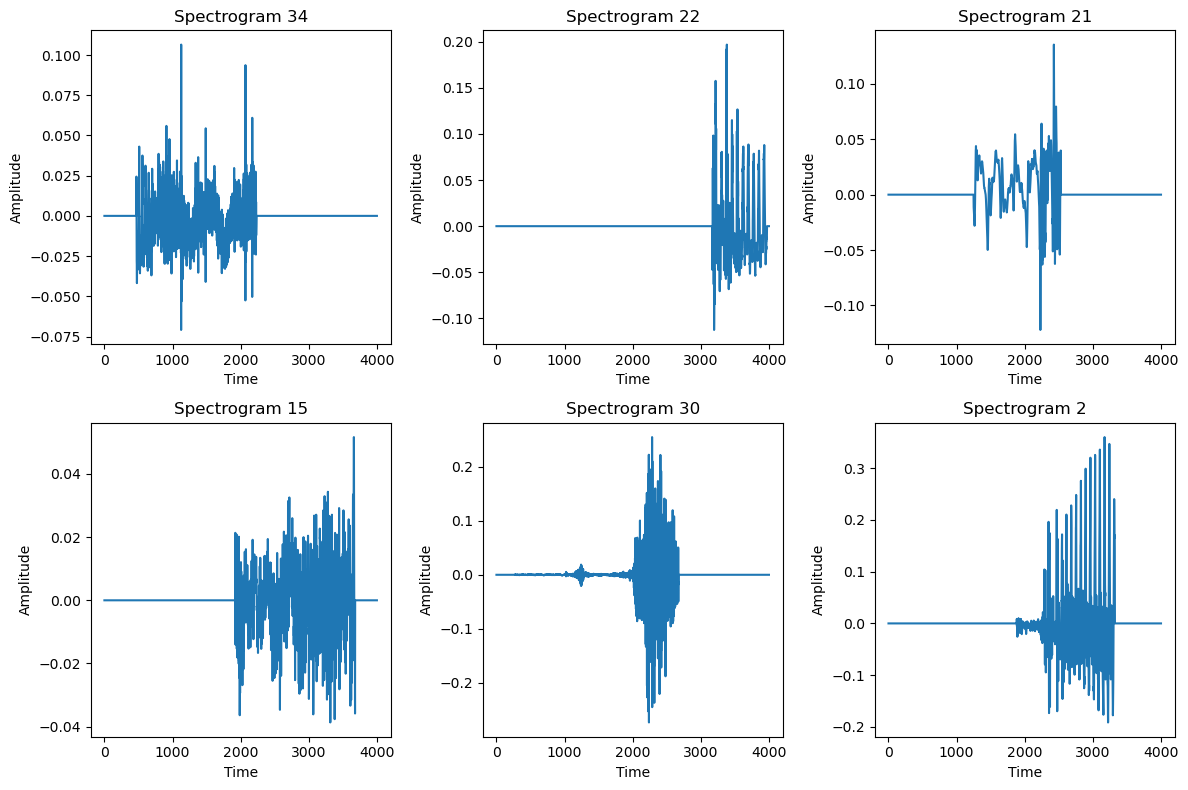

In [25]:
# Set the random seed for reproducibility
random.seed(101)
# Generate six random indices
random_indices = random.sample(range(len(xx_pad)), 6)

# Plot the spectrograms and mark the corresponding seg
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    spectrogram = xx_pad[idx]
    segment = seg[idx]
    
    ax = axes[i]
    img = ax.plot(spectrogram[0].numpy())
    # ax.axvline(x=segment, color='red', linestyle='--')
    # ax.axvline(x=segment[1], color='red', linestyle='--')
    ax.set_title(f'Spectrogram {segment}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
plt.tight_layout()
# plt.colorbar(img,ax=axes)
plt.show()

In [15]:
# # Set the random seed for reproducibility
# random.seed(101)
# # Generate six random indices
# random_indices = random.sample(range(len(xx_pad)), 6)

# # Plot the spectrograms and mark the corresponding seg
# fig, axes = plt.subplots(2, 3, figsize=(12, 8))
# axes = axes.flatten()

# for i, idx in enumerate(random_indices):
#     spectrogram = xx_pad[idx]
#     segment = seg[idx]
    
#     ax = axes[i]
#     img = ax.imshow(spectrogram[0], aspect='auto', origin="lower")
#     # ax.axvline(x=segment, color='red', linestyle='--')
#     # ax.axvline(x=segment[1], color='red', linestyle='--')
#     ax.set_title(f'Spectrogram {segment}')
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Frequency')
# plt.tight_layout()
# plt.colorbar(img,ax=axes)
# plt.show()

## Init Model

In [30]:
# class JudgeNetwork(nn.Module):
#     def __init__(self, dimconf:ModelDimConfigs):
#         super().__init__()
#         conv_layers = []

#         self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
#         self.relu1 = nn.ReLU()
#         self.bn1 = nn.BatchNorm2d(8)
#         init.kaiming_normal_(self.conv1.weight, a=0.1)
#         self.conv1.bias.data.zero_()
#         conv_layers += [self.conv1, self.relu1, self.bn1]

#         # Adjust the other convolutional blocks accordingly

#         self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
#         self.relu2 = nn.ReLU()
#         self.bn2 = nn.BatchNorm2d(16)
#         init.kaiming_normal_(self.conv2.weight, a=0.1)
#         self.conv2.bias.data.zero_()
#         conv_layers += [self.conv2, self.relu2, self.bn2]

#         # Adjust the other convolutional blocks accordingly

#         self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
#         self.relu3 = nn.ReLU()
#         self.bn3 = nn.BatchNorm2d(32)
#         init.kaiming_normal_(self.conv3.weight, a=0.1)
#         self.conv3.bias.data.zero_()
#         conv_layers += [self.conv3, self.relu3, self.bn3]

#         self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
#         self.relu4 = nn.ReLU()
#         self.bn4 = nn.BatchNorm2d(64)
#         init.kaiming_normal_(self.conv4.weight, a=0.1)
#         self.conv4.bias.data.zero_()
#         conv_layers += [self.conv4, self.relu4, self.bn4]

#         self.ap = nn.AdaptiveAvgPool2d(output_size=1)
#         self.lin = nn.Linear(in_features=64, out_features=39)

#         self.conv = nn.Sequential(*conv_layers)

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.ap(x)
#         x = x.view(x.shape[0], -1)
#         x = self.lin(x)
#         return x

#     def predict_on_output(self, output): 
#         output = nn.Softmax(dim=1)(output)
#         preds = torch.argmax(output, dim=1)
#         return preds

In [26]:
class JudgeNetwork(nn.Module):
    def __init__(self, dimconf:ModelDimConfigs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=244, stride=4), 
            nn.ReLU(), 
            nn.BatchNorm1d(128), 
            nn.MaxPool1d(kernel_size=4), 
            nn.Conv1d(128, 256, kernel_size=3), 
            nn.ReLU(), 
            nn.BatchNorm1d(256), 
            nn.MaxPool1d(kernel_size=4), 
            nn.Conv1d(256, 512, kernel_size=3), 
            nn.ReLU(), 
            nn.BatchNorm1d(512), 
            nn.MaxPool1d(kernel_size=4),  
        )
        self.ap = nn.AdaptiveAvgPool1d(output_size=1)
        self.lin = nn.Linear(in_features=512, out_features=39)
    def forward(self, x):
        x = self.conv(x)
        x = self.ap(x)
        x = x.view(x.shape[0], -1)
        x = self.lin(x)
        return x

    def predict_on_output(self, output): 
        output = nn.Softmax(dim=1)(output)
        preds = torch.argmax(output, dim=1)
        return preds

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
# NOTE: no need to mask the loss, because we don't do reconstruction. 

dimconf = ModelDimConfigs(
        rnn_in_size=TrainingConfigs.N_MELS, 
        lin_in_size_1=256, 
        lin_in_size_2=ds.mapper.token_num(), 
        lin_out_size_2=ds.mapper.token_num()
    )

model = JudgeNetwork(
    dimconf=dimconf
)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_str = str(model)
model_txt_path = os.path.join(model_save_dir, "model.txt")

with open(model_txt_path, "w") as f:
    f.write(model_str)

In [28]:
print(str(summary(model, input_size=(128, 1, 4000))))

Layer (type:depth-idx)                   Output Shape              Param #
JudgeNetwork                             [128, 39]                 --
├─Sequential: 1-1                        [128, 512, 14]            --
│    └─Conv1d: 2-1                       [128, 128, 940]           31,360
│    └─ReLU: 2-2                         [128, 128, 940]           --
│    └─BatchNorm1d: 2-3                  [128, 128, 940]           256
│    └─MaxPool1d: 2-4                    [128, 128, 235]           --
│    └─Conv1d: 2-5                       [128, 256, 233]           98,560
│    └─ReLU: 2-6                         [128, 256, 233]           --
│    └─BatchNorm1d: 2-7                  [128, 256, 233]           512
│    └─MaxPool1d: 2-8                    [128, 256, 58]            --
│    └─Conv1d: 2-9                       [128, 512, 56]            393,728
│    └─ReLU: 2-10                        [128, 512, 56]            --
│    └─BatchNorm1d: 2-11                 [128, 512, 56]            1,0

In [29]:
model

JudgeNetwork(
  (conv): Sequential(
    (0): Conv1d(1, 128, kernel_size=(244,), stride=(4,))
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
    (9): ReLU()
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (ap): AdaptiveAvgPool1d(output_size=1)
  (lin): Linear(in_features=512, out_features=39, bias=True)
)

## Load Model if READ

In [30]:
def draw_learning_curve_and_accuracy(losses, accs, epoch="", best_val=None, save=False, save_name=""): 
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    train_losses, valid_losses, best_val_loss = losses
    train_accs, valid_accs = accs

    # Plot Loss on the left subplot
    ax1.plot(train_losses, label='Train')
    ax1.plot(valid_losses, label='Valid')
    ax1.axvline(x=best_val_loss, color='r', linestyle='--', label=f'Best: {best_val_loss}')
    ax1.set_title("Learning Curve Loss" + f" {epoch}")
    ax1.legend(loc="upper right")

    # Plot Accuracy on the right subplot
    ax2.plot(train_accs, label='Train')
    ax2.plot(valid_accs, label='Valid')
    if best_val: 
        ax2.axhline(y=best_val, color='r', linestyle='--', label=f'Best: {best_val:.3f}')
    ax2.set_title('Learning Curve Accuracy' + f" {epoch}")
    ax2.legend(loc="lower right")

    # Display the plots
    plt.tight_layout()
    plt.xlabel("Epoch")
    display.clear_output(wait=True)
    display.display(plt.gcf())
    if save: 
        plt.savefig(save_name)

In [31]:
if READ: 
    valid_losses.read()
    train_losses.read()

    model_raw_name = f"{stop_epoch}"
    model_name = model_raw_name + ".pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

In [32]:
best_valid_loss = 1e9
best_valid_loss_epoch = 0

In [36]:
EPOCHS = 50
BASE = 50

In [37]:
def train(best_valid_loss, best_valid_loss_epoch): 
    for epoch in range(BASE, BASE + EPOCHS):
        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        train_correct = 0
        train_total = 0
        for idx, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            
            x = x.to(device)
            y = torch.tensor(y, device=device)

            y_hat = model(x)
            loss = criterion(y_hat, y)
            train_loss += loss.item()

            loss.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            # 这个函数计算的是全局梯度范数
            # torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=5, norm_type=2)
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
            # parameters: an iterable of Variables that will have gradients normalized
            # max_norm: max norm of the gradients(阈值设定)
            # norm_type: type of the used p-norm. Can be'inf'for infinity norm(定义范数类型)

            optimizer.step()
            pred = model.predict_on_output(y_hat)

            train_total += y_hat.size(0)
            train_correct += (pred == y).sum().item()

            draw_progress_bar(idx, train_num, title="Train")

        train_losses.append(train_loss / train_num)
        train_accs.append(train_correct / train_total)

        last_model_name = f"{epoch}.pt"
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))

        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        valid_correct = 0
        valid_total = 0
        for idx, (x, y) in enumerate(valid_loader):
            x = x.to(device)
            y = torch.tensor(y, device=device)

            y_hat = model(x)
            loss = criterion(y_hat, y)
            valid_loss += loss.item()

            pred = model.predict_on_output(y_hat)

            valid_total += y_hat.size(0)
            valid_correct += (pred == y).sum().item()

            # draw_progress_bar(idx, valid_num, title="Valid")

        avg_valid_loss = valid_loss / valid_num
        valid_losses.append(avg_valid_loss)
        valid_accs.append(valid_correct / valid_total)
        if avg_valid_loss < best_valid_loss: 
            best_valid_loss = avg_valid_loss
            best_valid_loss_epoch = epoch

        draw_learning_curve_and_accuracy(losses=(train_losses.get(), valid_losses.get(), best_valid_loss_epoch), 
                                         accs=(train_accs.get(), valid_accs.get()), 
                                         epoch=str(epoch))
        train_losses.save()
        valid_losses.save()
        train_accs.save()
        valid_accs.save()

    return best_valid_loss, best_valid_loss_epoch

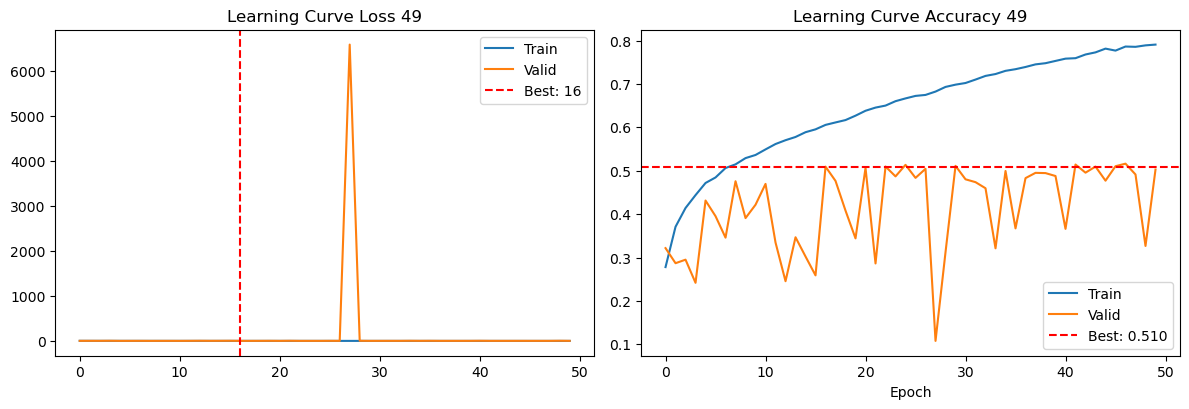

<Figure size 640x480 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

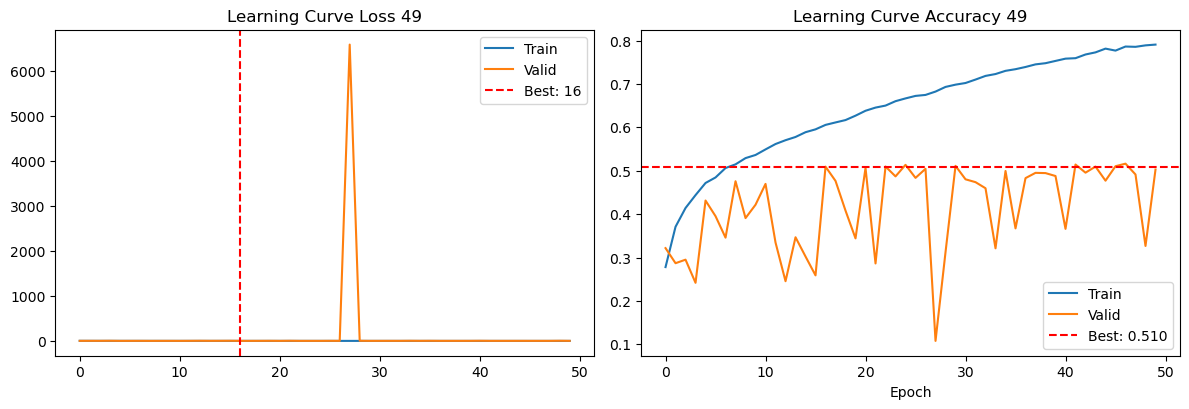

In [35]:
if __name__ == "__main__": 
    best_valid_loss, best_valid_loss_epoch = train(best_valid_loss, best_valid_loss_epoch)
    draw_learning_curve_and_accuracy(losses=(train_losses.get(), valid_losses.get(), best_valid_loss_epoch), 
                                    accs=(train_accs.get(), valid_accs.get()), 
                                    epoch=str(BASE + EPOCHS - 1), 
                                    best_val=valid_accs.get()[best_valid_loss_epoch], 
                                    save=True, 
                                    save_name=f"{model_save_dir}/vis.png")